# Regression

ในการวิเคราะห์นี้จะแบ่งออกเป็น 2 ส่วน
1. Exploratory data analysis
+ Regression model

ในส่วนของ Exploratory data analysis จะเป็นการสำรวจข้อมูลที่จะนำมาใช้ในตัวแปรอย่างคร่าวๆ ขณะที่ Regression model เป็นการวิเคราะสมการถดถอยแบบพหุโดยใช้ฟังกชันก์พื้นฐานที่อยู่ใน base R สำหรับการทำ Regression ด้วยวิธี Gradient Descent นั้นคลิ๊กที่นี่

## นำเข้าข้อมูล

ข้อมูลที่จะใช้ในการวิเคราะห์ครั้งนี้จะเป็นข้อมูลเกี่ยวกับค่าจ้างแรงงานที่มีการสำหรับจากหลายภูมิภาคในประเทศอเมริกา ซึ่งจะมีข้อมูลรายบุคคลที่บอกรายละเอียดเกี่ยวกับ ค่าจ้าง ประสบการทำงาน การศึกษา การสมสร ภูมิภาคและอื่นๆ ข้อมูล dataset ได้มาจาก Introductory Econometrics: A Modern Approach โดย Jeffrey Wooldrige  
  
โดยข้อมูลที่จะนำเข้าเข้าเป็นข้อมูล local นามสกุล .dta ซึ่งสามารถอ่านได้โดยซอฟต์แวร์สถิติ Stata โดยจำนำเข้าโดยใช้แพ็คเกจ haven ซึ่งจะอ่านข้อมูลสกุล .dta เป็น dtl_df จากนั้นแปลงเป็นข้อมูล dataframe  
  
*(จำเป็นต้องเปลี่ยน path ของ working directory และ path ของไฟล์ด้วย)*

In [6]:
#import data
setwd("C:/Users/DELL/Desktop/Self Learning/git/R")
library(haven)
dtb <- read_dta(file="./dataset/WAGE1.dta")
df <- data.frame(dtb)
head(df)

Warning message:
"package 'haven' was built under R version 3.4.3"

wage,educ,exper,tenure,nonwhite,female,married,numdep,smsa,northcen,...,trcommpu,trade,services,profserv,profocc,clerocc,servocc,lwage,expersq,tenursq
3.10,11,2,0,0,1,0,2,1,0,...,0,0,0,0,0,0,0,1.131402,4,0
3.24,12,22,2,0,1,1,3,1,0,...,0,0,1,0,0,0,1,1.175573,484,4
3.00,11,2,0,0,0,0,2,0,0,...,0,1,0,0,0,0,0,1.098612,4,0
6.00,8,44,28,0,0,1,0,1,0,...,0,0,0,0,0,1,0,1.791759,1936,784
5.30,12,7,2,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1.667707,49,4
8.75,16,9,8,0,0,1,0,1,0,...,0,0,0,1,1,0,0,2.169054,81,64


# Exploratory data analysis

ในส่วนนี้จะดูข้อมูลพื้นฐานที่จะมาใช้กับแบบจำลองถดถอยแบบคร่าวๆ

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.530   3.330   4.650   5.896   6.880  24.980 

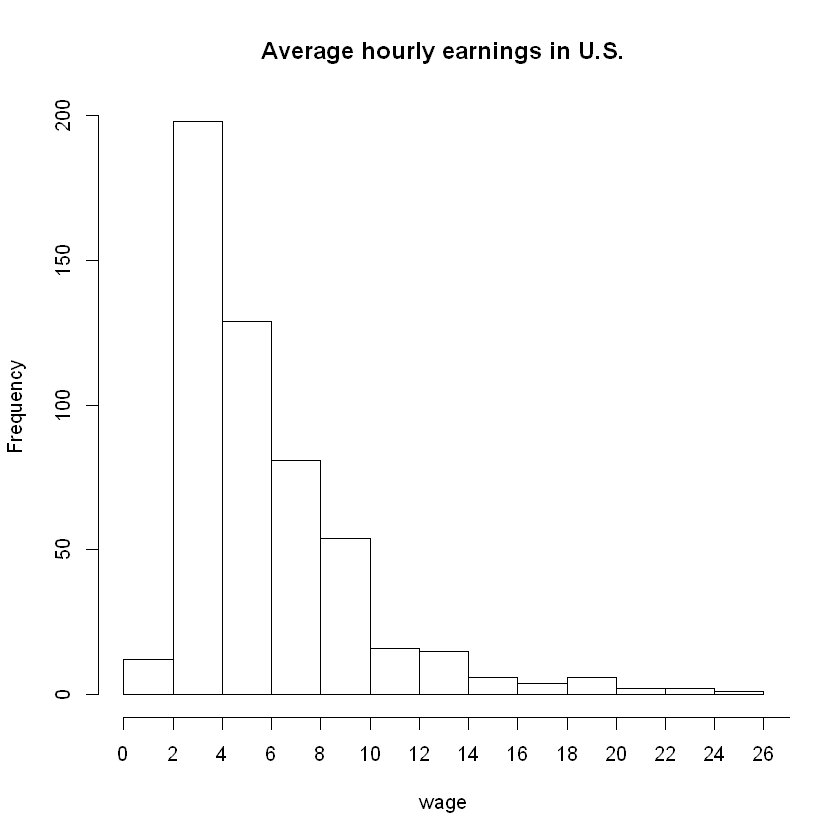

In [18]:
#Quick Exploratory data analysis(EDA) ####
#1.Univarate

summary(df$wage)
hist(df$wage, main="Average hourly earnings in U.S." ,xlab="wage" , axes=FALSE)
axis(2)
axis(1, at=seq(0,28, by=2), labels=seq(0,28, by=2))

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.00   12.00   12.56   14.00   18.00 

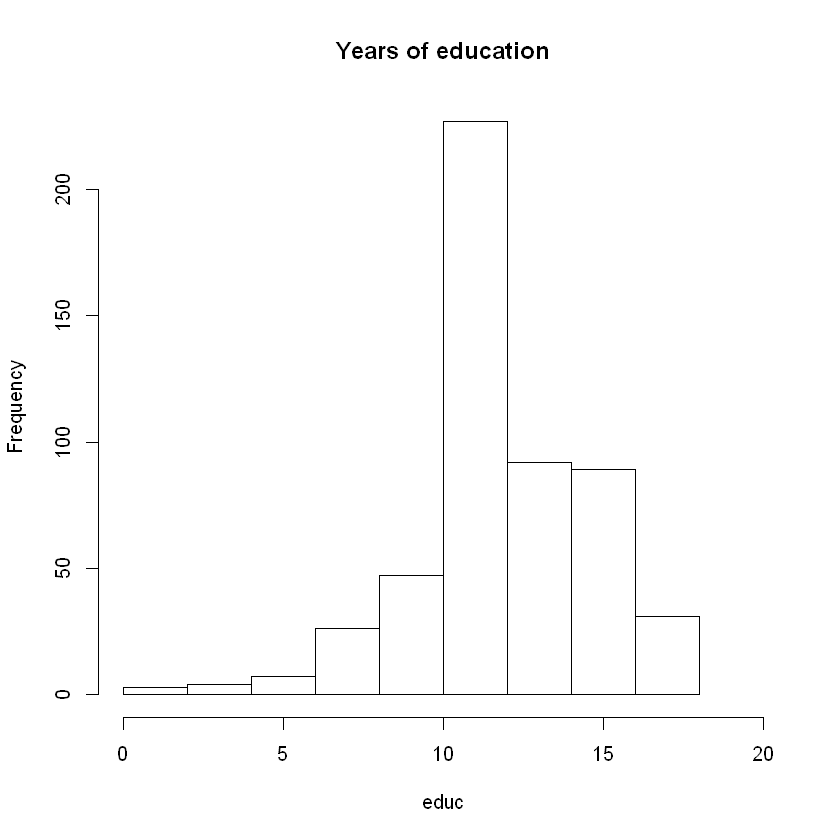

In [50]:
summary(df$educ)
hist(df$educ, main="Years of education", xlab="educ", xlim=c(0,20))

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    5.00   13.50   17.02   26.00   51.00 

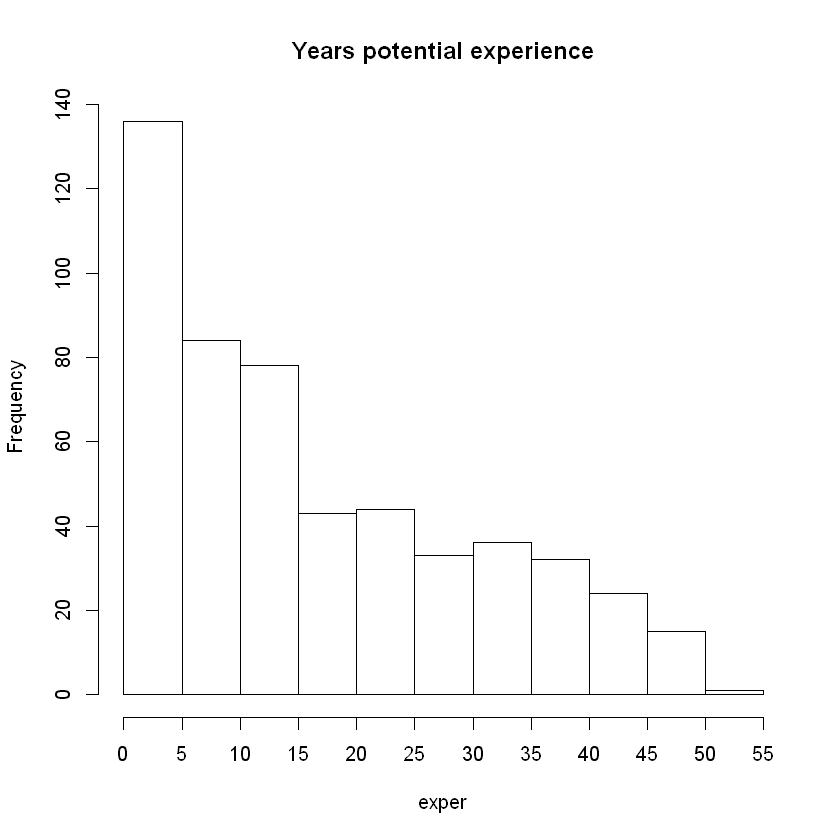

In [28]:
summary(df$exper)
hist(df$exper, main="Years potential experience", xlab="exper")
axis(2)
axis(1, at=seq(0,55, by=5), labels=seq(0,55, by=5))

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   2.000   5.105   7.000  44.000 

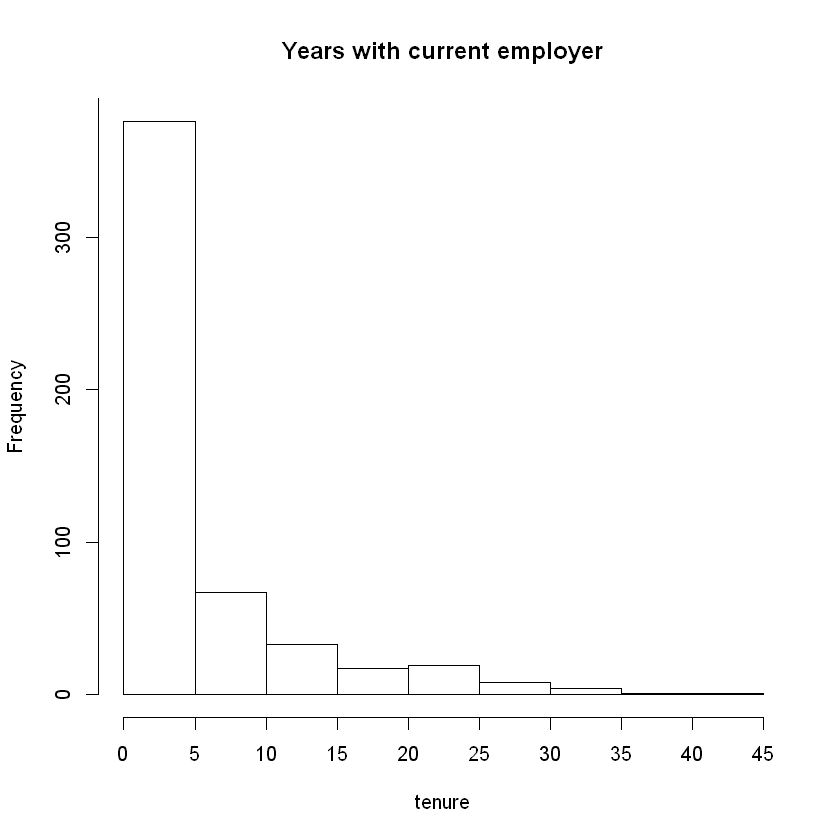

In [51]:
summary(df$tenure)
hist(df$tenure, main="Years with current employer", xlab="tenure")
axis(2, at=seq(0,400, by=100), labels=seq(0,400, by=100))
axis(1, at=seq(0,45, by=5), labels=seq(0,45, by=5))

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

### ข้อมูลตัวแปรดัมมี่

เนื่องจาก base R ไม่ได้แผนภูมิวงกลมที่แสดงร้อยละมาให้ ผมจึ่งเขี่ยนฟังก์ชัน pct_pie ที่จะสร้างแผนภูมิวงกลมที่สามารถกำหนดสี หัวข้อ การแบ่งตนึ่ง และความเข้มจางได้

In [33]:
pct_pie <- function(x, lb=c("Cat1","Cat2"), cl=c("cyan","pink"), tt="Title", center=FALSE ,fade=FALSE) {
  ft <- factor(x)
  pct <- round(table(ft)*100/sum(table(ft)))
  lb <- paste(lb, pct)
  lb <- paste(lb,"%",sep="")
    
  if (center==TRUE & fade==TRUE){
    pie(table(ft), col=cl, labels = lb, main=tt, init.angle = 270, density=50)
  } else if (center==TRUE & fade==FALSE) {
    pie(table(ft), col=cl, labels = lb, main=tt, init.angle = 270)
  } else if (center==FALSE & fade==TRUE) {
    pie(table(ft), col=cl, labels = lb, main=tt, density=50)
  } else {
    pie(table(ft), col=cl, labels = lb, main=tt)
  }
  freqeuncy_table <- ft  
  return(table(freqeuncy_table))
}

freqeuncy_table
  0   1 
472  54 

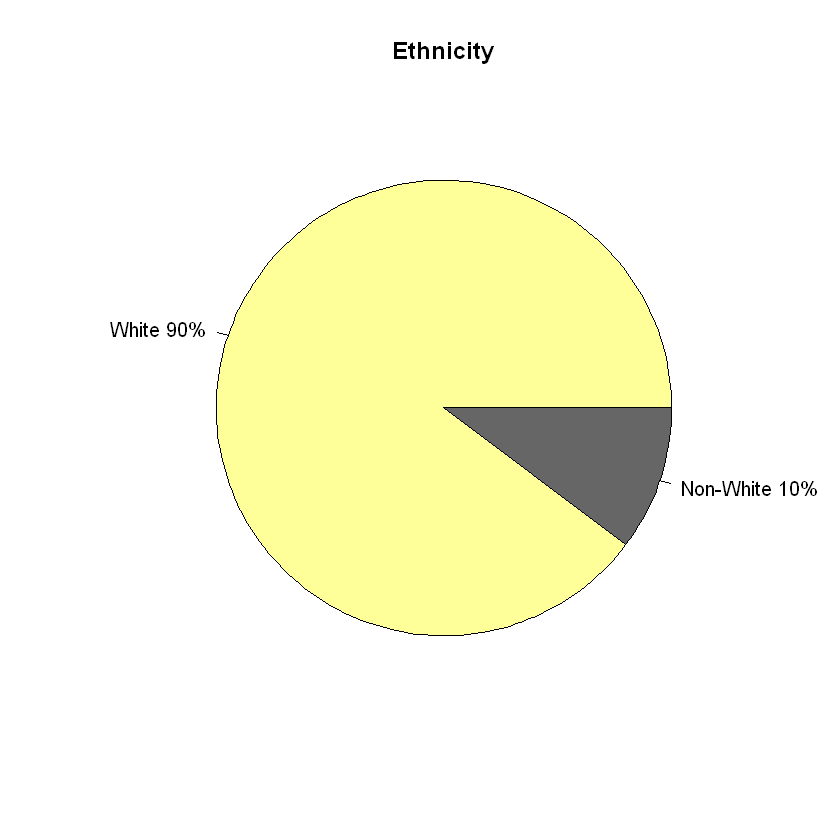

In [34]:
pct_pie(df$nonwhite, cl=c("#ffff99","#666666"),
        tt="Ethnicity", lb=c("White", "Non-White"))

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

freqeuncy_table
  0   1 
274 252 

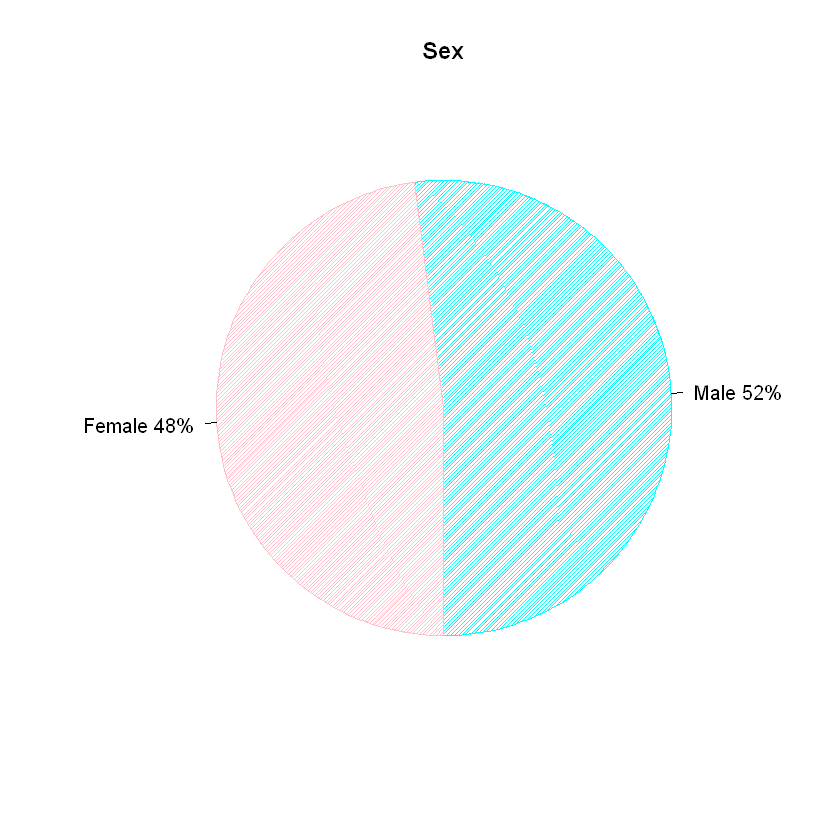

In [35]:
pct_pie(df$female, lb=c("Male", "Female"), cl=c("cyan","pink"),tt = "Sex",
        center = TRUE, fade=TRUE)

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

freqeuncy_table
  0   1 
206 320 

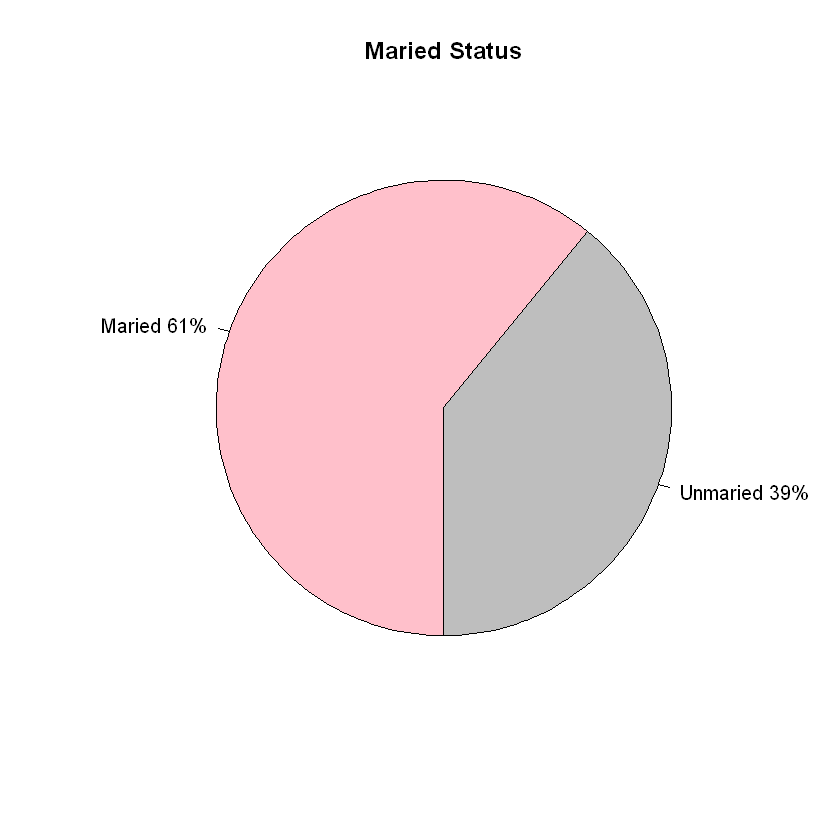

In [36]:
pct_pie(df$married, lb=c("Unmaried","Maried"), cl=c("grey","pink")
        , tt="Maried Status", center=TRUE)

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

In [42]:
region_table <- sapply(list(df$northcen, df$south, df$west), table)
colnames(region_table) <- c("NE","S","W")
rownames(region_table) <- c("No (0)", "Yes (1)")
region_table

,NE,S,W
No (0),394,339,437
Yes (1),132,187,89


(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

เนื่องจากตัวแปรภูมิภาคเป็นแบบดัมมี่ซึ่งเหมาะแก่การวิเคราะห์เชิงเศษฐมิคิ แต่ไม่เหมาะสำหรับการ visualise จึงต้องรวมเป็นตัวแปรเดียวกันเสียก่อน

In [43]:
df2 <- df
df2$region <- NA
df2$region[df$northcen==1] <- 1
df2$region[df$south==1] <- 2
df2$region[df$west==1] <- 3
df2$region[is.na(df2$region)] <- 4
table(df2$region)


  1   2   3   4 
132 187  89 118 

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)


  2   1   4   3 
187 132 118  89 

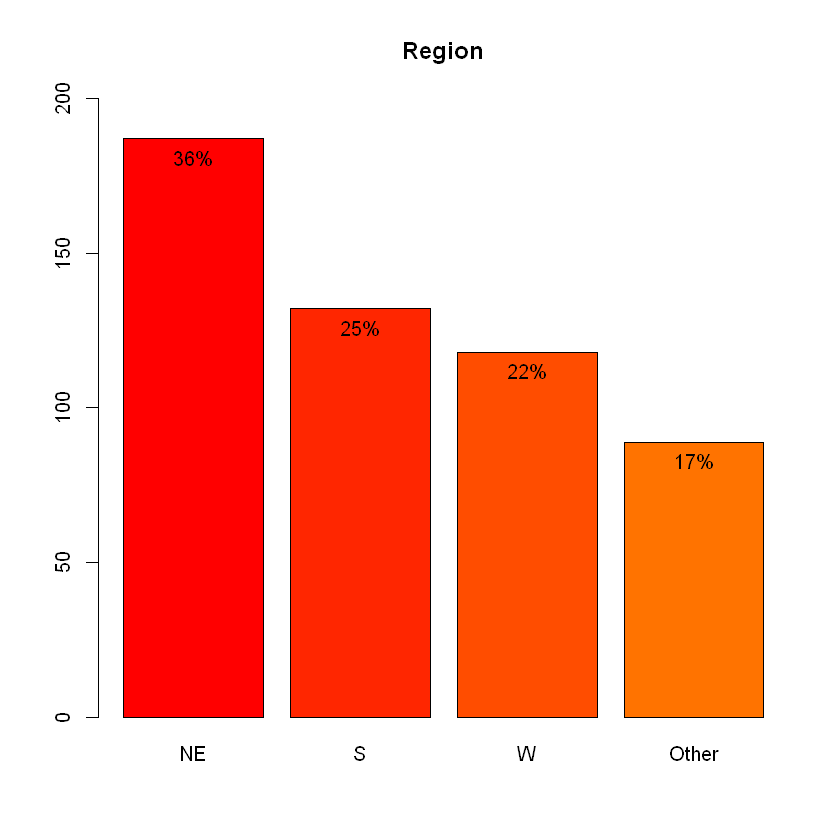

In [44]:
freq <- table(df2$region)[order(table(df2$region), decreasing = TRUE)]
pfreq <- round(freq*100/sum(freq))
pfreq <- paste(pfreq,"%",sep="")

p <- barplot(freq, col=rainbow(40), names.arg =c("NE","S","W","Other"),
             main="Region", ylim=c(0,200))
text(x = p, y = freq, label = pfreq, pos = 1, cex = 1, col = "black")

table(df2$region)[order(table(df2$region), decreasing = TRUE)]

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

# Regression model

ในส่วนนี้จะเป็นการวิเคราะแบบจำลองถดถอยเพื่ออธิบายค่าจ้าง โดยจะเริ่มจากแบบจำลองที่เรียบง่ายก่อน

In [45]:
#Regression model ####
model1 <- lm(wage ~ educ+exper,data=df)
summary(model1)


Call:
lm(formula = wage ~ educ + exper, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5532 -1.9801 -0.7071  1.2030 15.8370 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.39054    0.76657  -4.423 1.18e-05 ***
educ         0.64427    0.05381  11.974  < 2e-16 ***
exper        0.07010    0.01098   6.385 3.78e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.257 on 523 degrees of freedom
Multiple R-squared:  0.2252,	Adjusted R-squared:  0.2222 
F-statistic: 75.99 on 2 and 523 DF,  p-value: < 2.2e-16


(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

In [46]:
model2 <- lm(wage ~ educ+exper+expersq,data=df)
summary(model2)


Call:
lm(formula = wage ~ educ + exper + expersq, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0692 -2.0837 -0.5417  1.2860 15.1363 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.964890   0.752153  -5.271 1.99e-07 ***
educ         0.595343   0.053025  11.228  < 2e-16 ***
exper        0.268287   0.036897   7.271 1.31e-12 ***
expersq     -0.004612   0.000822  -5.611 3.26e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.166 on 522 degrees of freedom
Multiple R-squared:  0.2692,	Adjusted R-squared:  0.265 
F-statistic: 64.11 on 3 and 522 DF,  p-value: < 2.2e-16


(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

In [47]:
model3 <- lm(wage ~ educ+exper+expersq+tenure, data=df)
summary(model3)


Call:
lm(formula = wage ~ educ + exper + expersq + tenure, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-8.259 -1.844 -0.465  1.126 14.200 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.4198669  0.7175124  -4.766 2.44e-06 ***
educ         0.5564740  0.0505889  11.000  < 2e-16 ***
exper        0.2051075  0.0359866   5.700 2.01e-08 ***
expersq     -0.0042021  0.0007821  -5.373 1.17e-07 ***
tenure       0.1614708  0.0211388   7.639 1.06e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.005 on 521 degrees of freedom
Multiple R-squared:  0.3428,	Adjusted R-squared:  0.3378 
F-statistic: 67.95 on 4 and 521 DF,  p-value: < 2.2e-16


(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

In [48]:
model4 <- lm(wage ~ educ+exper+expersq+tenure+nonwhite+female+smsa, data=df)
summary(model4)


Call:
lm(formula = wage ~ educ + exper + expersq + tenure + nonwhite + 
    female + smsa, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.7286 -1.6496 -0.4188  1.1089 13.5140 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.376398   0.718872  -3.306  0.00101 ** 
educ         0.496534   0.049398  10.052  < 2e-16 ***
exper        0.212266   0.034263   6.195 1.19e-09 ***
expersq     -0.004240   0.000744  -5.699 2.02e-08 ***
tenure       0.129967   0.020503   6.339 5.04e-10 ***
nonwhite    -0.190439   0.411875  -0.462  0.64401    
female      -1.826950   0.255901  -7.139 3.19e-12 ***
smsa         0.915255   0.286504   3.195  0.00149 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.855 on 518 degrees of freedom
Multiple R-squared:  0.4105,	Adjusted R-squared:  0.4025 
F-statistic: 51.53 on 7 and 518 DF,  p-value: < 2.2e-16


(จองพื้นที่ไว้เพื่อเขียนอธิบาย)

In [49]:
model5 <- lm(wage ~ educ+exper+expersq+tenure+nonwhite+female+smsa+northcen+south+west, data=df)
summary(model5)


Call:
lm(formula = wage ~ educ + exper + expersq + tenure + nonwhite + 
    female + smsa + northcen + south + west, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8947 -1.6947 -0.4179  1.1617 13.4701 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.9803352  0.7598406  -2.606  0.00942 ** 
educ         0.4949868  0.0492377  10.053  < 2e-16 ***
exper        0.2146396  0.0343335   6.252 8.53e-10 ***
expersq     -0.0042669  0.0007454  -5.724 1.77e-08 ***
tenure       0.1281942  0.0204160   6.279 7.24e-10 ***
nonwhite    -0.1601583  0.4111599  -0.390  0.69705    
female      -1.8653886  0.2546749  -7.325 9.30e-13 ***
smsa         0.7659055  0.2911138   2.631  0.00877 ** 
northcen    -0.5409944  0.3603263  -1.501  0.13386    
south       -0.5993109  0.3438981  -1.743  0.08198 .  
west         0.4541613  0.3994139   1.137  0.25604    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.835 on 

(จองพื้นที่ไว้เพื่อเขียนอธิบาย)